In [160]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy import stats

from lifetimes import ParetoNBDFitter
from lifetimes import BetaGeoFitter
import lifetimes
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.utils import summary_data_from_transaction_data
from pymc_marketing import clv

df = pd.read_csv('online_retail_II.csv')
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [161]:
#df = pd.read_excel('Online Retail.xlsx')


def data_preprocessing(df):
    df = df.rename(columns={'Customer ID': 'CustomerID', 'Price': 'UnitPrice'})

    df = df[df['CustomerID'].notna()].reset_index(drop=True)
    df = df[df.Quantity > 0]
    df = df[df.UnitPrice > 0]
    non_product_codes = ['POST', 'D', 'M', 'C2', 'BANK CHARGES', 'AMAZONFEE', 'DCGSSBOY', 
                         'DCGSSGIRL', 'DOT', 'PADS', 'TEST001','TEST002', 'ADJUST', 'ADJUST2','SP1002']

    df = df[~df['StockCode'].isin(non_product_codes)]

    #time features engeneering
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
    df['Date'] = df['InvoiceDate'].dt.date
    df['Month'] = df['InvoiceDate'].dt.to_period('M')
    
    df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
    df['Amount'] = df['Quantity'] * df['UnitPrice']
    df = df[(np.abs(stats.zscore(df['TotalPrice'])) < 3.5)]
    df = df[(np.abs(stats.zscore(df['Quantity'])) < 3.5)]
    


    #ebedding for the country and description columns
    
    df = df[df.Month != '2011-12']
    df = df.rename(columns = {'Invoice':'InvoiceNo'})

    return df

df = data_preprocessing(df)

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date,Month,TotalPrice,Amount
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,2009-12-01,2009-12,83.4,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2009-12-01,2009-12,81.0,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2009-12-01,2009-12,81.0,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,2009-12-01,2009-12,100.8,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,2009-12-01,2009-12,30.0,30.0


In [162]:
df.CustomerID.nunique()

5791

In [163]:
def generate_rfm_data (df, last_transaction_date = pd.to_datetime('2011-12-09')):
    agg_function = {
    'CustomerID': 'first',
    'Amount': 'sum',
    'Date': 'min',
    'Country': 'first'}

    orders_df = df.groupby('InvoiceNo').agg(agg_function).reset_index()
    orders_df.drop(orders_df.index[orders_df.Amount <=0], axis = 0, inplace = True)
    rfm = summary_data_from_transaction_data(transactions=orders_df,
                                         customer_id_col='CustomerID',
                                         datetime_col='Date',
                                         monetary_value_col = 'Amount',
                                         observation_period_end=last_transaction_date,
                                         freq='D',
                                        include_first_transaction = True)
    return rfm, orders_df

def get_orders_df (df):
    agg_function = {
    'CustomerID': 'first',
    'Amount': 'sum',
    'Date': 'min',
    'Country': 'first'}

    orders_df = df.groupby('InvoiceNo').agg(agg_function).reset_index()
    orders_df.drop(orders_df.index[orders_df.Amount <=0], axis = 0, inplace = True)
    return orders_df

def generate_calibration_and_holdout (df, last_transaction_date = '2011-12-09', offset = 30 ):
    orders_df = get_orders_df(df)
    rfm = calibration_and_holdout_data(transactions=orders_df,
                                         customer_id_col='CustomerID',
                                         datetime_col='Date',
                                         monetary_value_col = 'Amount',
                                         freq = 'D',
                                         calibration_period_end=pd.to_datetime(last_transaction_date) - pd.DateOffset(days=offset),
                                         observation_period_end=pd.to_datetime(last_transaction_date)
                                        ).reset_index()
    data = (
    rfm[[ "CustomerID", 'frequency_cal', 'recency_cal', 'T_cal', 'monetary_value_cal']]
    .rename(columns={'CustomerID':'customer_id',
                    'frequency_cal':'frequency',
                      'recency_cal':'recency',
                    'monetary_value_cal':'monetary_value',
                     'T_cal': 'T'
                    })

    )
    data_holdout = (
    rfm[[ "CustomerID", 'frequency_holdout', 'monetary_value_holdout']]
    .rename(columns={'CustomerID':'customer_id',
                     'frequency_holdout':'frequency',
                     'monetary_value_holdout':'monetary_value'
                     })
    )
    return data, data_holdout

def generate_calibration_and_holdout_2 (df, last_transaction_date = '2011-12-09', offset = 30 ):
   orders_df = get_orders_df(df)
   rfm = clv.utils.rfm_train_test_split(transactions=orders_df,
                                         customer_id_col='CustomerID',
                                         datetime_col='Date',
                                         monetary_value_col = 'Amount',
                                         time_unit = 'D',
                                         train_period_end=pd.to_datetime(last_transaction_date) - pd.DateOffset(days=offset),
                                         test_period_end=pd.to_datetime(last_transaction_date)
                                        ).reset_index()
   rfm = rfm[rfm['monetary_value'] <=2000]
   data = rfm[[ "customer_id", 'frequency', 'recency', 'T', 'monetary_value']]
   data_holdout = (
    rfm[[ "customer_id", 'test_frequency', 'test_monetary_value']]
    .rename(columns={
                     'test_frequency':'frequency',
                     'test_monetary_value':'monetary_value'
                     })
    )
   return data, data_holdout

def transaction_churn_model_lt(data, prob_model = 'ParetoNBD', library  = 'pymc'):
    if library != 'pymc':
        if prob_model == 'ParetoNBD':
            model = ParetoNBDFitter()
        else:
          model = lifetimes.BetaGeoFitter(penalizer_coef=0.0)

        model.fit(data['frequency'], data['recency'], data['T'])
        return model
    if prob_model == 'ParetoNBD':
        model = clv.ParetoNBDModel(data = data)
    else:
        model =clv.BetaGeoModel(data = data)
    model.fit()
    return model

def predict_trasactions_churn(data, model, future_t = 52,  library = 'pymc'):
  if library != 'pymc':
    number_of_transactions = model.conditional_expected_number_of_purchases_up_to_time(t = future_t,
                        frequency = data['frequency'],
                        recency = data['recency'],
                         T = data['T'])
    alive_prob = model.conditional_probability_alive(
                        frequency = data['frequency'],
                        recency = data['recency'],
                         T = data['T'])

  else:
    number_of_transactions = model.expected_purchases(future_t = future_t, data = data).mean(axis=(0, 1))
    alive_prob = model.expected_probability_alive(data = data).mean(axis = (0, 1))
  return number_of_transactions, alive_prob


def gg_model(rfm):
  nonzero_data = rfm.query('frequency > 0')
  print('monetary value - frequency correlation: ', nonzero_data[["monetary_value", "frequency"]].corr())

  gg = clv.GammaGammaModel(data = nonzero_data)
  gg.build_model()
  gg.fit()
  return gg

def predict_clv(rfm, model, future_t):
  expected_spend = model.expected_customer_spend(data = rfm)
  expected_monetary_value = expected_spend.mean(axis = (0, 1)).to_dataframe(name = 'expected_spend').reset_index()
  return expected_monetary_value

In [189]:
rfm_cal, rfm_holdout = generate_calibration_and_holdout_2(df, last_transaction_date = '2011-11-30', offset = 91)
rfm_cal.head()

,customer_id,frequency,recency,T,monetary_value
0,12346.0,1.0,118.0,547.0,142.31
1,12347.0,5.0,275.0,304.0,650.61
2,12348.0,3.0,190.0,338.0,389.08
3,12349.0,1.0,182.0,489.0,1152.62
4,12350.0,0.0,0.0,210.0,0.00


In [188]:
rfm_holdout.customer_id.nunique(), rfm_holdout.customer_id.nunique()


(5172, 5172)

In [182]:
#bg_lt = transaction_churn_model_lt(rfm_cal, prob_model = 'BG-NBD', library  = 'lt')
bg_lt = transaction_churn_model_lt(rfm_cal, prob_model = 'ParetoNBD', library  = 'pymc')

Output()

In [187]:
gg = gg_model(rfm_cal)

Initializing NUTS using jitter+adapt_diag...


monetary value - frequency correlation:                  monetary_value  frequency
monetary_value        1.000000   0.162653
frequency             0.162653   1.000000


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, q, v]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


In [190]:
future_transactions, alive_prob = predict_trasactions_churn(rfm_cal, bg_lt, future_t = 91, library = 'pymc')
rfm_holdout['expected_transactions'] = future_transactions
rfm_holdout['expected_alive_prob'] = alive_prob
#rfm_holdout['expected_alive_prob']= rfm_holdout['expected_alive_prob'].apply(lambda x: 0 if x <0.3 else x)
#rfm_holdout['expected_transactions']= rfm_holdout['expected_transactions'].apply(lambda x: 0 if x <0.3 else x)

expected_monetary_value = predict_clv(rfm_holdout, gg, future_t = 90)
rfm_holdout = pd.merge(rfm_holdout, expected_monetary_value, on = 'customer_id', how = 'left')
rfm_holdout['expected_clv'] = rfm_holdout.expected_spend * rfm_holdout.expected_transactions
rfm_holdout['real_clv'] = rfm_holdout.monetary_value * rfm_holdout.frequency

rfm_holdout.head()

,customer_id,frequency,monetary_value,expected_transactions,expected_alive_prob,expected_spend,expected_clv,real_clv
0,12346.0,0.0,0.00,0.188579,0.748017,373.459793,70.426769,0.00
1,12347.0,1.0,1294.32,1.365151,0.992015,700.332779,956.060282,1294.32
2,12348.0,1.0,270.00,0.750016,0.913225,336.713560,252.540431,270.00
3,12349.0,1.0,1457.55,0.243986,0.877453,758.277138,185.008885,1457.55
4,12350.0,0.0,0.00,0.182610,0.791153,373.459793,68.197314,0.00


In [191]:
from sklearn.metrics import r2_score, mean_absolute_error

def smape(y_true, y_pred, epsilon = 1e-10):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  #y_true = np.maximum(y_true, 100) 
  denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
  diff = np.abs(y_true - y_pred)
  #denominator = np.where(denominator == 0, epsilon, denominator)
  smape_value = np.mean(diff / denominator)*100
  return smape_value

rmse = np.sqrt(mean_squared_error(rfm_holdout['real_clv'], rfm_holdout['expected_clv']))
print(rmse)
mae = mean_absolute_error(rfm_holdout['real_clv'], rfm_holdout['expected_clv'])
print(mae)
smape_value = smape(rfm_holdout['real_clv'], rfm_holdout['expected_clv'])
print(smape_value)

r2 = r2_score(rfm_holdout['real_clv'], rfm_holdout['expected_clv'])
print(r2)

931.6207454894128
294.6147920759643
146.13830961853193
0.5985928077706173


/var/folders/1y/r5jmwn4n0r599hsjjrhbwstm0000gn/T/ipykernel_20624/3541655507.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


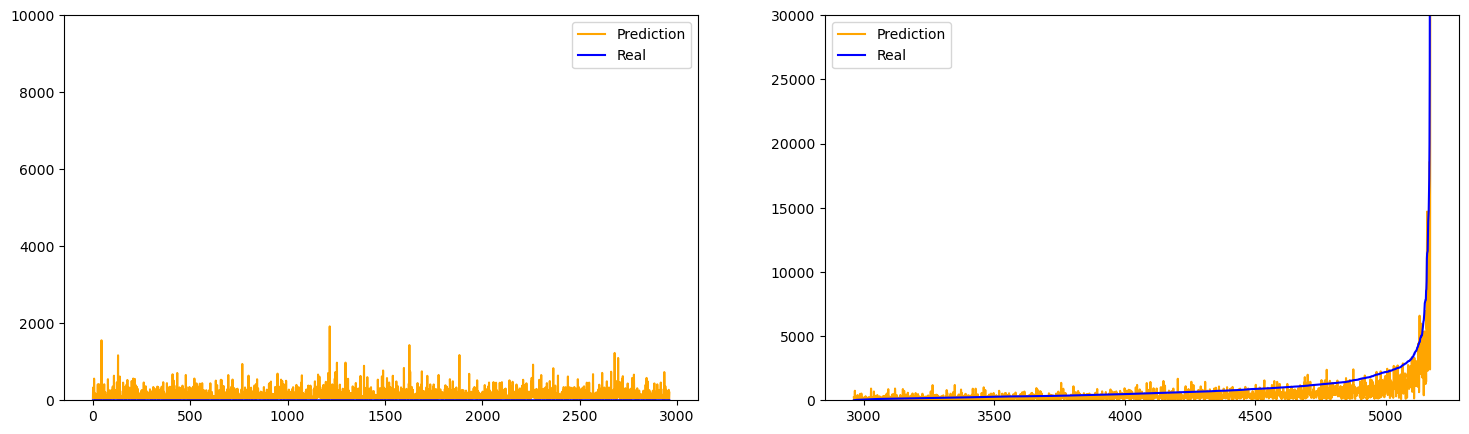

In [178]:
plot_data = rfm_holdout.sort_values(by = 'real_clv', ascending = True).reset_index(drop = True)
#plot_data = plot_data[plot_data.real_clv > 0]
positive_df = plot_data[plot_data['real_clv'] > 0]
zero_df = plot_data[plot_data['real_clv'] == 0]
#test_smooth = smooth_funct(plot_data['expected_clv'].values)

fig, ax = plt.subplots(1,2, figsize = (18, 5))
ax[1].plot( positive_df['expected_clv'], color = 'orange', label = 'Prediction')
ax[1].plot( positive_df['real_clv'],color  = 'blue', label  = 'Real')
#ax[1].set_ylim(0, 5e5)
ax[1].legend()
ax[0].plot( zero_df['expected_clv'], color = 'orange', label = 'Prediction')
ax[0].plot( zero_df['real_clv'], color  = 'blue', label  = 'Real')
ax[0].legend()
ax[1].set_ylim(0, 30000)
ax[0].set_ylim(0, 10000)
fig.show()

In [181]:

prob_results = rfm_holdout[['expected_clv','real_clv']]
prob_results.rename(columns = {'expected_clv': 'Predictions', 'real_clv': 'Targets'}, inplace = True)
prob_results.to_csv('probabilistic_model_results.csv', index = False)
prob_results.describe()

,Predictions,Targets
count,5172.000000,5172.000000
mean,301.360584,404.618188
std,789.747210,1470.579695
min,0.000031,0.000000
25%,62.055392,0.000000
50%,137.815872,0.000000
75%,302.392640,409.880000
max,30516.281936,58961.090000


In [180]:
prob_results[prob_results['Targets'] == 0].shape

(2961, 2)

In [30]:
np.log(100/90)

0.10536051565782635

In [31]:
np.log(100/110)

-0.0953101798043249